In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from dotenv import load_dotenv
load_dotenv()

import matplotlib.pyplot as plt

# Load Data from AT

In [2]:
from airtable import airtable
at = airtable.Airtable(os.getenv('AIRTABLE_BASE_ID'), os.getenv('AIRTABLE_API_KEY'))
records = at.get('RSS_feed')

In [3]:
records['offset']

'itrfEgPVpnHCmuUOe/rec2JB6lrFvsHJIny'

In [4]:
import requests
base_id = os.getenv('AIRTABLE_BASE_ID')
table_name = "RSS_feed"
url = "https://api.airtable.com/v0/" + base_id + "/" + table_name
api_key = os.getenv('AIRTABLE_API_KEY')
headers = {"Authorization": "Bearer " + api_key}
params = ()
response = requests.get(url, params=params, headers=headers)

In [5]:
params = ()
airtable_records = []
run = True
while run is True:
  response = requests.get(url, params=params, headers=headers)
  airtable_response = response.json()
  airtable_records += (airtable_response['records'])
  if "offset" in airtable_response:
     run = True
     params = (("offset", airtable_response["offset"]),)
  else:
     run = False

In [6]:
import pandas as pd
airtable_records
airtable_rows = [] 
airtable_index = []
for record in airtable_records:
    airtable_rows.append(record['fields'])
    airtable_index.append(record['id'])
df = pd.DataFrame(airtable_rows, index=airtable_index)

df.head()

,summary,title,sentiment,link,date,score
rec006zxjRZxyc6WG,Responding to extreme drought conditions in pa...,Extreme Drought in U.S. Prompts Emergency Crop...,Negative,https://www.insurancejournal.com/news/midwest/...,2021-07-14,NaN
rec04UtXlR9M0jFeQ,Marsh has partnered with banking group Citi to...,Marsh and Citi develop non-payment cover for g...,Negative,https://www.theinsurer.com/news/marsh-and-citi...,2021-08-17,-1.0
rec05LJRftoFL6TG2,BRASILIA – A regional labor judge has ordered ...,Brazil Judge Orders Vale to Pay Damages to Fam...,Negative,https://www.insurancejournal.com/news/internat...,2021-06-11,NaN
rec06Z0QDazShds1T,Reich is on track to hit its £100m of gross wr...,Reich targeting £120m GWP within five years,Negative,https://www.postonline.co.uk/broker/7833966/re...,2021-05-17,NaN
rec07RecP5xnnSbrC,The CEO also pledged revived investment in gro...,Willis CEO Haley confirms year-end retirement,Negative,https://www.insuranceinsider.com/article/28vlg...,2021-08-03,NaN


In [7]:
df['sentiment']=df['sentiment'].replace({'Negative':0,'Neutral':1,'Positive':2})

In [8]:
df.head()

,summary,title,sentiment,link,date,score
rec006zxjRZxyc6WG,Responding to extreme drought conditions in pa...,Extreme Drought in U.S. Prompts Emergency Crop...,0,https://www.insurancejournal.com/news/midwest/...,2021-07-14,NaN
rec04UtXlR9M0jFeQ,Marsh has partnered with banking group Citi to...,Marsh and Citi develop non-payment cover for g...,0,https://www.theinsurer.com/news/marsh-and-citi...,2021-08-17,-1.0
rec05LJRftoFL6TG2,BRASILIA – A regional labor judge has ordered ...,Brazil Judge Orders Vale to Pay Damages to Fam...,0,https://www.insurancejournal.com/news/internat...,2021-06-11,NaN
rec06Z0QDazShds1T,Reich is on track to hit its £100m of gross wr...,Reich targeting £120m GWP within five years,0,https://www.postonline.co.uk/broker/7833966/re...,2021-05-17,NaN
rec07RecP5xnnSbrC,The CEO also pledged revived investment in gro...,Willis CEO Haley confirms year-end retirement,0,https://www.insuranceinsider.com/article/28vlg...,2021-08-03,NaN


## Create train, test and val dataframes

In [9]:
import numpy as np
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

2669 training examples
334 validation examples
334 test examples


## Prepare tf datasets

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('sentiment')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [11]:
batch_size = 100
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/var/folders/86/_czxb88d1vs6dlr9r1cb7mh80000gn/T/ipykernel_39002/2714832384.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
2021-11-09 10:48:30.682455: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
train_ds.element_spec

({'summary': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'title': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'sentiment': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None),
  'link': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'date': TensorSpec(shape=(None, 1), dtype=tf.string, name=None),
  'score': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

# Select BERT Model

In [13]:
tfhub_handle_encoder='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Define model

In [27]:
def build_classifier_model():
  summary_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='summary')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(summary_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, name='classifier')(net)
  return tf.keras.Model(summary_input, net)

In [28]:
classifier_model = build_classifier_model()

## Train model

In [29]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [30]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [31]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [32]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
27/27 [==============================] - 229s 8s/step - loss: 1.1361 - sparse_categorical_accuracy: 0.4350 - val_loss: 0.9738 - val_sparse_categorical_accuracy: 0.5210
Epoch 2/5
27/27 [==============================] - 224s 8s/step - loss: 0.9099 - sparse_categorical_accuracy: 0.5740 - val_loss: 0.9166 - val_sparse_categorical_accuracy: 0.5629
Epoch 3/5
27/27 [==============================] - 230s 9s/step - loss: 0.8314 - sparse_categorical_accuracy: 0.6163 - val_loss: 0.8732 - val_sparse_categorical_accuracy: 0.5958
Epoch 4/5
27/27 [==============================] - 221s 8s/step - loss: 0.7704 - sparse_categorical_accuracy: 0.6605 - val_loss: 0.8525 - val_sparse_categorical_accuracy: 0.6347
Epoch 5/5
27/27 [==============================] - 222s 8s/step - loss: 0.7485 - sparse_categorical_accuracy: 0.6707 - val_loss: 0.8442 - val_sparse_categorical_accuracy: 0.6467


In [33]:
tf.sigmoid(classifier_model.predict(test_ds))

<tf.Tensor: shape=(334, 3), dtype=float32, numpy=
array([[0.34214526, 0.65512043, 0.71972674],
       [0.21416602, 0.63645196, 0.6104304 ],
       [0.9044427 , 0.14285997, 0.11771062],
       ...,
       [0.6932451 , 0.4979465 , 0.55039227],
       [0.11304924, 0.43238357, 0.8950833 ],
       [0.20967227, 0.45500425, 0.7972606 ]], dtype=float32)>

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


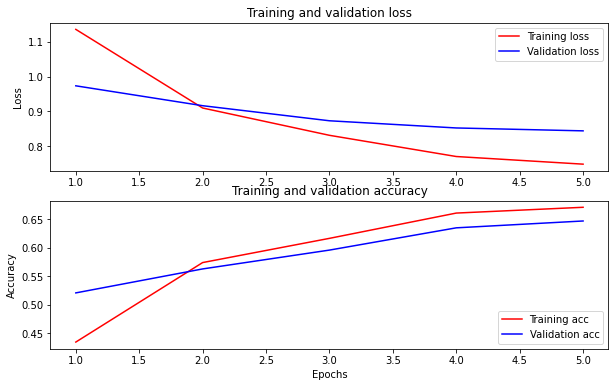

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')